In [1]:
import os, warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (10, 5)

# Base path = notebook's parent directory
BASE_DIR = os.getcwd()
DATA_PATH = os.path.join(BASE_DIR, "data", "Online Retail.xlsx")
RESULTS_DIR = os.path.join(BASE_DIR, "results")
os.makedirs(RESULTS_DIR, exist_ok=True)

print("Data path:", DATA_PATH)
print("Results path:", RESULTS_DIR)


Data path: G:\Professionial\Portfolio\retail sales forecasting\data\Online Retail.xlsx
Results path: G:\Professionial\Portfolio\retail sales forecasting\results


In [2]:
df = pd.read_excel(DATA_PATH, engine="openpyxl")
print("Raw rows:", len(df))
df.head()


Raw rows: 541909


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
COUNTRY = ""   # change "" for all countries

df = df.dropna(subset=["InvoiceNo", "StockCode", "Description",
                       "Quantity", "InvoiceDate", "UnitPrice"])
df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], errors="coerce")
df = df.dropna(subset=["InvoiceDate"])
df["Revenue"] = df["Quantity"] * df["UnitPrice"]

if COUNTRY and "Country" in df.columns:
    df = df[df["Country"] == COUNTRY]

monthly = (df.set_index("InvoiceDate")
             .resample("MS")["Revenue"]
             .sum()
             .to_frame("Revenue"))
monthly = monthly.loc[monthly["Revenue"] > 0]

print("Monthly periods:", len(monthly))
monthly.head()


Monthly periods: 13


,Revenue
InvoiceDate,
2010-12-01,823746.140
2011-01-01,691364.560
2011-02-01,523631.890
2011-03-01,717639.360
2011-04-01,537808.621


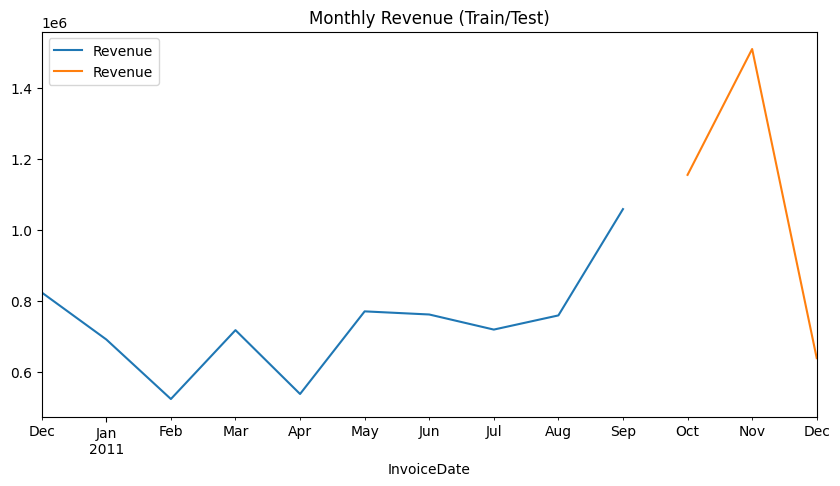

In [4]:
split_idx = int(len(monthly) * 0.8)
train = monthly.iloc[:split_idx].copy()
test  = monthly.iloc[split_idx:].copy()

ax = train.plot(label="Train")
test.plot(ax=ax, label="Test")
ax.set_title("Monthly Revenue (Train/Test)")
ax.legend()
plt.savefig(os.path.join(RESULTS_DIR, "train_test_plot.png"), dpi=150)
plt.show()


In [5]:
ORDER = (1,1,1)
SEASONAL_ORDER = (1,1,1,12)

model = None
res = None
err_msg = None

try:
    model = SARIMAX(train["Revenue"],
                    order=ORDER,
                    seasonal_order=SEASONAL_ORDER,
                    enforce_stationarity=False,
                    enforce_invertibility=False)
    res = model.fit(disp=False)
    display(res.summary())
except Exception as e:
    err_msg = f"SARIMAX failed: {e}"
    print(err_msg)



<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                            Revenue   No. Observations:                   10
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                   0.000
Date:                            Fri, 05 Sep 2025   AIC                             10.000
Time:                                    06:15:20   BIC                                nan
Sample:                                12-01-2010   HQIC                               nan
                                     - 09-01-2011                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1               0         -0        nan        nan           0           0
ma.L1               0         -0        nan        nan           0           0
ar.S.L12            0         -0        nan        nan           0           0
ma.S.L12            0         -0        nan        nan           0           0
sigma2         1.0000         -0       -inf      0.000       1.000       1.000
===================================================================================
Ljung-Box (L1) (Q):                    nan   Jarque-Bera (JB):                  nan
Prob(Q):                               nan   Prob(JB):                          nan
Heteroskedasticity (H):                nan   Skew:                              nan
Prob(H) (two-sided):                   nan   Kurtosis:                          nan
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

Train: 11 points | Test: 2 points
Best model: SARIMAX(0, 1, 2)x(0, 0, 0, 0), AIC=188.0
MAE=460,232  RMSE=546,110


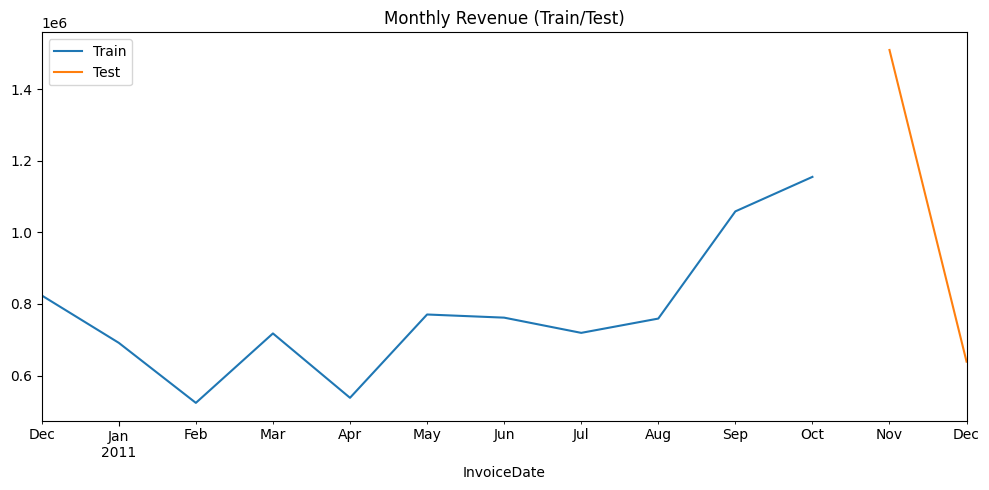

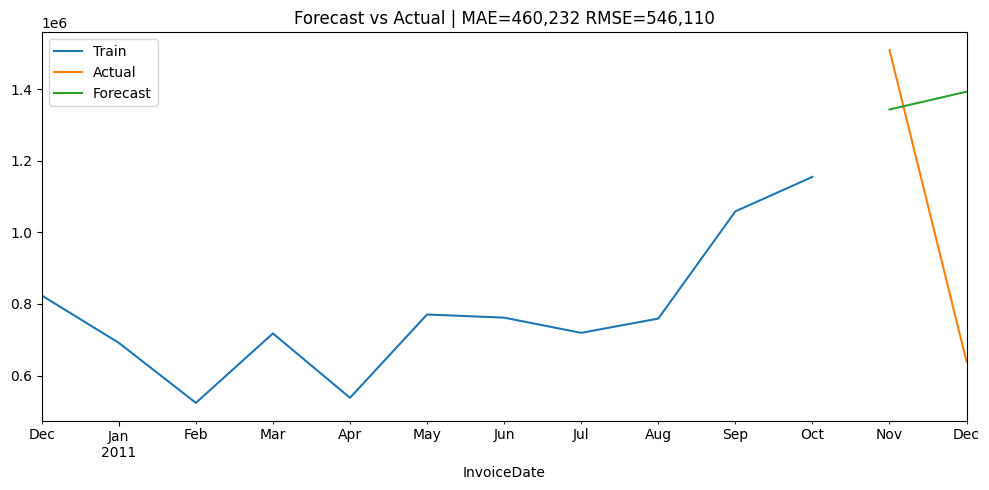

ValueError: Length of endogenous variable must be larger the the number of lags used in the model and the number of observations burned in the log-likelihood calculation.

<Figure size 1200x800 with 0 Axes>

In [13]:
# Requires: monthly (DataFrame with column "Revenue"), RESULTS_DIR defined

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np, matplotlib.pyplot as plt, os, pandas as pd

# 1) Train/Test split (80/20, chronological)
series = monthly["Revenue"].astype(float)
split_idx = int(len(series) * 0.90)
train, test = series.iloc[:split_idx], series.iloc[split_idx:]

print(f"Train: {len(train)} points | Test: {len(test)} points")

# 2) Try several reasonable SARIMAX/ARIMA specs; pick best by AIC
candidates = [
    ((0,1,1),(0,0,0,0)), ((1,1,0),(0,0,0,0)), ((1,1,1),(0,0,0,0)), ((0,1,2),(0,0,0,0)),
]


best = None  # (aic, order, seasonal_order, fitted_result)
for order, seas in candidates:
    try:
        m = SARIMAX(train, order=order, seasonal_order=seas,
                    enforce_stationarity=False, enforce_invertibility=False)
        r = m.fit(disp=False)
        aic = r.aic
        if (best is None) or (aic < best[0]):
            best = (aic, order, seas, r)
    except Exception as e:
        # Uncomment to debug: print(f"Skipped {order}x{seas}: {e}")
        pass

# 3) Forecast
if best:
    aic, ORDER, SEASONAL_ORDER, res = best
    print(f"Best model: SARIMAX{ORDER}x{SEASONAL_ORDER}, AIC={aic:,.1f}")
    fc = res.get_forecast(steps=len(test))
    pred = fc.predicted_mean
    pred.index = test.index
else:
    res = None
    print("All SARIMAX fits failed → using naive fallback (last train value).")
    pred = pd.Series(np.full(len(test), train.iloc[-1]), index=test.index)

# 4) Metrics
mae  = mean_absolute_error(test, pred)
mse  = mean_squared_error(test, pred)
rmse = float(np.sqrt(mse))
print(f"MAE={mae:,.0f}  RMSE={rmse:,.0f}")

# 5) Plots + CSV (always saved)
os.makedirs(RESULTS_DIR, exist_ok=True)

# Train/Test split
ax = train.plot(label="Train")
test.plot(ax=ax, label="Test")
ax.set_title("Monthly Revenue (Train/Test)")
ax.legend()
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, "train_test_plot.png"), dpi=150)
plt.show()

# Forecast vs Actual
ax = train.plot(label="Train")
test.plot(ax=ax, label="Actual")
pred.plot(ax=ax, label="Forecast")
ax.set_title(f"Forecast vs Actual | MAE={mae:,.0f} RMSE={rmse:,.0f}")
ax.legend()
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, "monthly_sales.png"), dpi=150)
plt.show()

# CSV
pd.DataFrame({"actual": test, "forecast": pred}).to_csv(
    os.path.join(RESULTS_DIR, "forecast_vs_actual.csv")
)

# 6) Residual diagnostics (only if a SARIMAX fit succeeded)
if res is not None:
    res.plot_diagnostics(figsize=(12, 8))
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, "sarimax_diagnostics.png"), dpi=150)
    plt.show()
    print("Saved diagnostics plot.")
else:
    print("Diagnostics skipped (no fitted model).")
# === END REPLACEMENT CELL ===


In [10]:
if res is not None:
    try:
        res.plot_diagnostics(figsize=(12,8))
        plt.tight_layout()
        plt.savefig(os.path.join(RESULTS_DIR, "sarimax_diagnostics.png"), dpi=150)
        plt.show()
        print("Saved diagnostics.")
    except Exception as e:
        print("Diagnostics failed:", e)
else:
    print("Diagnostics skipped (no fitted model).")


Diagnostics failed: Length of endogenous variable must be larger the the number of lags used in the model and the number of observations burned in the log-likelihood calculation.


<Figure size 1200x800 with 0 Axes>

In [11]:
print("Top 5 months by revenue:")
print(monthly.sort_values("Revenue", ascending=False).head())

print("\nMonthly revenue stats:")
print(monthly["Revenue"].describe().round(2))


Top 5 months by revenue:
                 Revenue
InvoiceDate             
2011-11-01   1509496.330
2011-10-01   1154979.300
2011-09-01   1058590.172
2010-12-01    823746.140
2011-05-01    770536.020

Monthly revenue stats:
count         13.00
mean      820514.20
std       272577.29
min       523631.89
25%       691364.56
50%       759138.38
75%       823746.14
max      1509496.33
Name: Revenue, dtype: float64
